In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.getcwd()) + "/utils/")

from graphing_utils import *
from markov_utils import *
from rsm_model_utils import *
from wolfram_utils import *

from concurrent.futures import ThreadPoolExecutor

import wolframclient
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from wolframclient.serializers import export
from fractions import Fraction
import sympy as sym

In [ ]:
"""
Set up wolfram session

Get wolfram kernel path: https://reference.wolfram.com/language/WolframClientForPython/docpages/basic_usages.html
Get wolfram license: https://software.berkeley.edu/mathematica
"""

wolfram_kernel_path_macos = "/Applications/Wolfram.app/Contents/MacOS/WolframKernel"
wolfram_kernel_path_linux = "/usr/local/Wolfram/Desktop/11.3/Executables/WolframKernel"
wolfram_kernel_path_windows = (
    "C:\\Program Files\\Wolfram Research\\Wolfram Desktop\\11.3\\WolframKernel.exe"
)

"""Define your own desired wolfram_kernel_path"""
my_wolfram_kernel_path = wolfram_kernel_path_macos


wolfram_session_manager = WolframSessionManager(my_wolfram_kernel_path)

# If this fails, check your wolfram path
wolfram_session = wolfram_session_manager.start_session()
wolfram_session.evaluate(wlexpr("1 + 1"))

In [ ]:
"""
Define typical RSM failure parameters
"""

conservative_failure_params = FailureParameters(
    failure_rps=Fraction(1, 50 * 24),
    recovery_rps=Fraction(1, 5),
    human_recovery_rps=Fraction(1, 5),
    update_rps=Fraction((60 * 60 * 1000), 10),
    outdate_rps=Fraction((60 * 60 * 1000), 10),
)

bad_failure_params = FailureParameters(
    failure_rps=Fraction(1, 50 * 24) * 2,
    recovery_rps=Fraction(1, 5),
    human_recovery_rps=Fraction(1, 5),
    update_rps=Fraction((60 * 60 * 1000), 10),
    outdate_rps=Fraction((60 * 60 * 1000), 10),
)

sym_failure_params_capital = FailureParameters(
    failure_rps=sym.Symbol("B"),
    recovery_rps=sym.Symbol("R"),
    human_recovery_rps=sym.Symbol("H"),
    update_rps=sym.Symbol("U"),
    outdate_rps=sym.Symbol("O"),
)

sym_failure_params_lowercase = FailureParameters(
    failure_rps=sym.Symbol("b"),
    recovery_rps=sym.Symbol("r"),
    human_recovery_rps=sym.Symbol("h"),
    update_rps=sym.Symbol("u"),
    outdate_rps=sym.Symbol("o"),
)

In [25]:
"""
Test generate and evaluate MTTF for a replicated state machine
"""
cmm = get_dr_backup_cmm(3, 2, conservative_failure_params, conservative_failure_params)
# cmm = get_dr_cmm(3, conservative_failure_params)
# cmm = get_dr_good_bad_cmm(2, 1, conservative_failure_params, conservative_failure_params)


wolfram_mm = get_wolfram_markov_model(cmm)
failed_wolfram_id = get_wolfram_failed_id(cmm)

round(get_mtt_state(wolfram_mm, failed_wolfram_id, wolfram_session) / 24 / 365.25, 2)

10683669.42

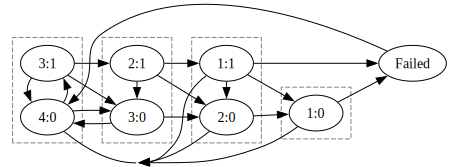

In [8]:
cmm = get_dr_cmm(4, conservative_failure_params)
get_graphviz(cmm, node_to_group=working_and_backup_grouping(cmm))

In [ ]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
failure_rates = generate_fractions(Fraction(1, 1000 * 24), Fraction(1, 50 * 24), 20)
x_axis_fr = [float(x) * 24 * 365.25 for x in failure_rates]

mttf_fr_results = [(n, []) for n in range(3,8)]

mttdl_fr_results = [((n,b), []) for n in range(3, 8) for b in range(3)]

for failure_rps in failure_rates:
    params = FailureParameters(
        failure_rps=failure_rps,
        recovery_rps=Fraction(1, 5),
        human_recovery_rps=Fraction(1, 5),
        update_rps=Fraction((60 * 60 * 1000), 10),
        outdate_rps=Fraction((60 * 60 * 1000), 10),
    )
    # Evaluate mttf results
    for n, cur_results in mttf_fr_results:
        cmm = get_dr_cmm(n, params)
        wolfram_mm = get_wolfram_markov_model(cmm)
        failed_wolfram_id = get_wolfram_failed_id(cmm)
        ans = get_mtt_state(wolfram_mm, failed_wolfram_id, wolfram_session)
        cur_results.append(ans / 24 / 365.25)

    # Evaluate mttdl results
    for (n, b), cur_results in mttdl_fr_results:
        cmm = get_dr_backup_cmm(n, b, params, params)
        wolfram_mm = get_wolfram_markov_model(cmm)
        failed_wolfram_id = get_wolfram_failed_id(cmm)
        ans = get_mtt_state(wolfram_mm, failed_wolfram_id, wolfram_session)
        cur_results.append(ans / 24 / 365.25)

In [18]:
mttf_fr_lines = [
    Line(x_values=x_axis_fr, y_values=y_vals, name=f'MTTF_{num_nodes}')
    for (num_nodes, y_vals) in mttf_fr_results
]

mttdl_fr_lines = [
    Line(x_values=x_axis_fr, y_values=y_vals, name=f'MTTDL_{num_nodes}_{num_backups}_')
    for (num_nodes, num_backups), y_vals in mttdl_fr_results
]

mttf_vs_failure_rate = Graph(
    title="mttf vs failure rate/year",
    x_axis_name="failure rate/yr",
    y_axis_name="mttf (years)",
    lines=mttf_fr_lines + mttdl_fr_lines,
)

make_fig(mttf_vs_failure_rate)

In [26]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
human_recovery_rates = generate_fractions(Fraction(1, 1000 * 24), Fraction(1, 50 * 24), 20)
x_axis_hr = [float(x) * 24 * 365.25 for x in human_recovery_rates]

mttf_hr_results = [(n, []) for n in range(3,8)]

mttdl_hr_results = [((n,b), []) for n in range(3, 8) for b in range(3)]


for human_recovery_rate in human_recovery_rates:
    params = FailureParameters(
        failure_rps=Fraction(1,5),
        recovery_rps=Fraction(1, 5),
        human_recovery_rps=human_recovery_rate,
        update_rps=Fraction((60 * 60 * 1000), 10),
        outdate_rps=Fraction((60 * 60 * 1000), 10),
    )
    # Evaluate mttf results
    for n, cur_results in mttf_hr_results:
        cmm = get_dr_cmm(n, params)
        wolfram_mm = get_wolfram_markov_model(cmm)
        failed_wolfram_id = get_wolfram_failed_id(cmm)
        ans = get_mtt_state(wolfram_mm, failed_wolfram_id, wolfram_session)
        cur_results.append(ans / 24 / 365.25)

    # Evaluate mttdl results
    for (n, b), cur_results in mttdl_hr_results:
        cmm = get_dr_backup_cmm(n, b, params, params)
        wolfram_mm = get_wolfram_markov_model(cmm)
        failed_wolfram_id = get_wolfram_failed_id(cmm)
        ans = get_mtt_state(wolfram_mm, failed_wolfram_id, wolfram_session)
        cur_results.append(ans / 24 / 365.25)

In [15]:
mttf_hr_lines = [
    Line(x_values=x_axis_hr, y_values=y_vals, name=f'MTTF_{num_nodes}')
    for (num_nodes, y_vals) in mttf_hr_results
]

mttdl_hr_lines = [
    Line(x_values=x_axis_hr, y_values=y_vals, name=f'MTTDL_{num_nodes}_{num_backups}')
    for (num_nodes, num_backups), y_vals in mttdl_hr_results
]

mttf_vs_failure_rate = Graph(
    title="mttf vs failure rate/year",
    x_axis_name="failure rate/yr",
    y_axis_name="mttf (years)",
    lines=mttf_hr_lines + mttdl_hr_lines,
)

make_fig(mttf_vs_failure_rate)